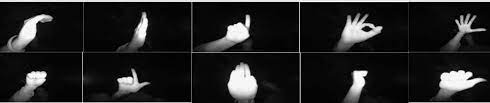

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
import glob 
import skimage as oi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU


2025-02-10 12:37:04.606169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 12:37:04.606296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 12:37:04.955713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = "/kaggle/input/leapgestrecog/leapGestRecog"
data = []

for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    if os.path.isdir(sub_dir_path):  
        for label in os.listdir(sub_dir_path):
            label_path = os.path.join(sub_dir_path, label)
            if os.path.isdir(label_path): 
                for image_file in os.listdir(label_path):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')): 
                        image_path = os.path.join(label_path, image_file)
                        data.append({'image_path': image_path, 'label': label})

df = pd.DataFrame(data)

# Split the data into training, testing, and validation sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42,shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42,shuffle=True)


print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 14000
Validation samples: 3000
Testing samples: 3000


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()


Y_train_int = label_encoder.fit_transform(train_df['label'])
Y_train = to_categorical(Y_train_int,10)

Y_val_int = label_encoder.transform(val_df['label'])
Y_val = to_categorical(Y_val_int,10)

Y_test_int = label_encoder.transform(test_df['label'])
Y_test = to_categorical(Y_test_int,10)


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def process_images(file_paths, target_size=(224, 224)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size) #rescale
        img_array = img_to_array(img) / 255.0  #normalize
        images.append(img_array)
    return np.array(images)


X_train = process_images(train_df['image_path'])
X_val = process_images(val_df['image_path'])
X_test = process_images(test_df['image_path'])


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(X_train)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Input,Dropout
from tensorflow.keras.models import Model

def identity_block(X, filters, kernel_size):
    F1, F2, F3 = filters
    
    
    X_shortcut = X
    
    # Reduction
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Filter
    X = Conv2D(F2, kernel_size, strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Expansion
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    # shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size, strides):
    F1, F2, F3 = filters
    # Where downsampling happens
    X_shortcut = X
    
    X = Conv2D(F1, (1, 1), strides=strides, padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, kernel_size, strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_shortcut = Conv2D(F3, (1, 1), strides=strides, padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape=(224, 224, 3), classes=1000):
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)
    
    # Stage 2
    X = convolutional_block(X, [64, 64, 256], kernel_size=(3, 3), strides=(1, 1))
    X = identity_block(X, [64, 64, 256], kernel_size=(3, 3))
    X = identity_block(X, [64, 64, 256], kernel_size=(3, 3))
    
    # Stage 3
    X = convolutional_block(X, [128, 128, 512], kernel_size=(3, 3), strides=(2, 2))
    X = identity_block(X, [128, 128, 512], kernel_size=(3, 3))
    X = identity_block(X, [128, 128, 512], kernel_size=(3, 3))
    X = identity_block(X, [128, 128, 512], kernel_size=(3, 3))
    
    # Stage 4
    X = convolutional_block(X, [256, 256, 1024], kernel_size=(3, 3), strides=(2, 2))
    for _ in range(5):
        X = identity_block(X, [256, 256, 1024], kernel_size=(3, 3))
    
    # Stage 5
    X = convolutional_block(X, [512, 512, 2048], kernel_size=(3, 3), strides=(2, 2))
    X = identity_block(X, [512, 512, 2048], kernel_size=(3, 3))
    X = identity_block(X, [512, 512, 2048], kernel_size=(3, 3))
    
    # Average Pooling
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model



In [7]:
model = ResNet50(input_shape=(224, 224, 3), classes=10)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy']) #SGD as used in the paper
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    tf.keras.callbacks.ModelCheckpoint("best.keras",save_best_only=True,monitor='val_loss', mode='min')
]

In [9]:
# Train the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=15,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1739191257.692021     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1739191257.759090     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


119/438 ━━━━━━━━━━━━━━━━━━━━ 2:34 486ms/step - accuracy: 0.1679 - loss: 2.9382

W0000 00:00:1739191315.173240     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.3773 - loss: 2.0529

W0000 00:00:1739191409.077864     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1739191423.351683     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 212s 380ms/step - accuracy: 0.3778 - loss: 2.0509 - val_accuracy: 0.7543 - val_loss: 0.7731
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 295ms/step - accuracy: 0.9467 - loss: 0.1769 - val_accuracy: 0.9730 - val_loss: 0.0834
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 293ms/step - accuracy: 0.9730 - loss: 0.0908 - val_accuracy: 0.4197 - val_loss: 5.3463
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 132s 296ms/step - accuracy: 0.9835 - loss: 0.0490 - val_accuracy: 0.9830 - val_loss: 0.0647
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 130s 293ms/step - accuracy: 0.9897 - loss: 0.0375 - val_accuracy: 0.9923 - val_loss: 0.0199
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 130s 293ms/step - accuracy: 0.9937 - loss: 0.0245 - val_accuracy: 0.9250 - val_loss: 0.2520
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 294ms/step - accuracy: 0.9942 - loss: 0.0226 - val_accuracy: 0.9987 - val_loss: 0.0046
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 294ms/step - accuracy: 0.9934 - loss: 0.02

In [10]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Testing Loss: {loss:.4f}")
print(f"Testing Accuracy : {accuracy*100:.2f} %")

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9785 - loss: 0.0474
Testing Loss: 0.0497
Testing Accuracy : 97.87 %


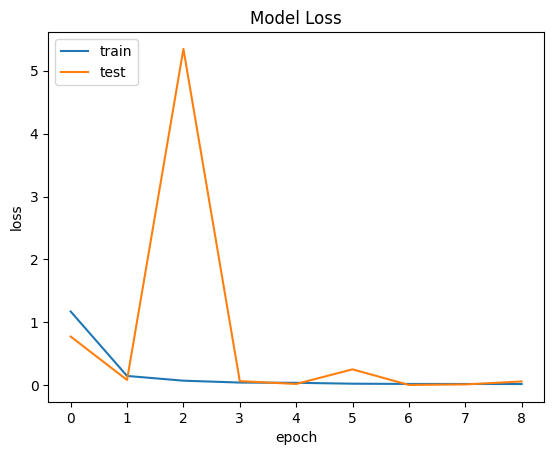

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

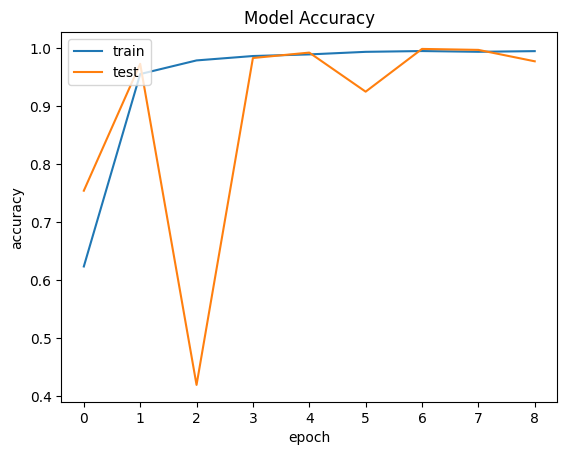

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 3/94 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step

W0000 00:00:1739192492.620831     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step


W0000 00:00:1739192503.074837     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


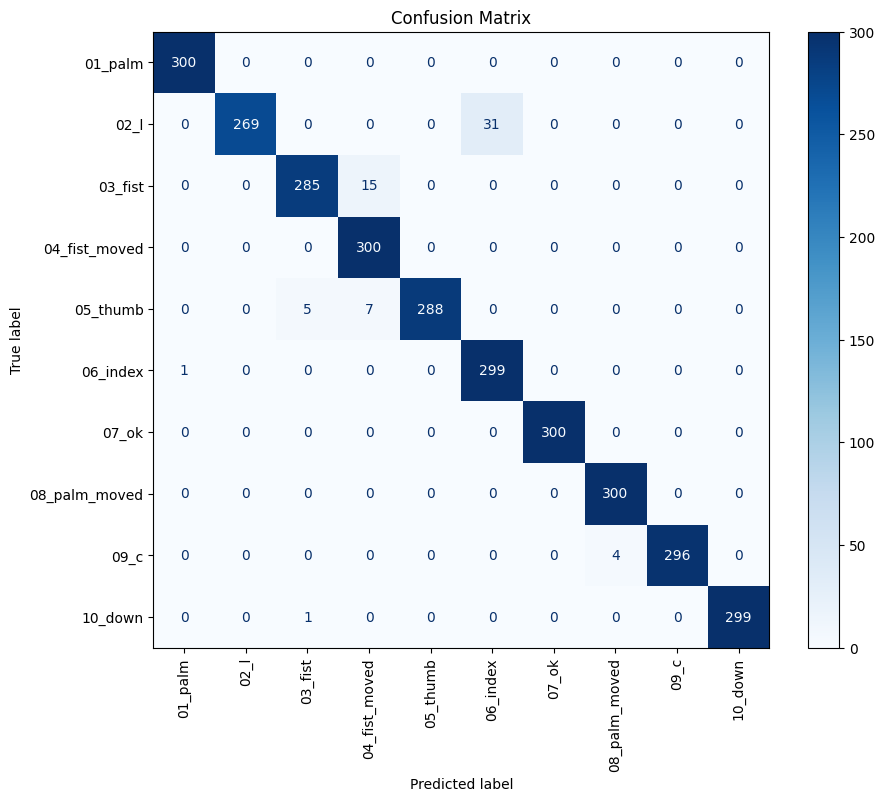

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = Y_test_int  # True labels (integer form)

# Compute
cm = confusion_matrix(y_true, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix")


plt.xticks(rotation=90)  

plt.show()


In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)


               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       300
         02_l       1.00      0.90      0.95       300
      03_fist       0.98      0.95      0.96       300
04_fist_moved       0.93      1.00      0.96       300
     05_thumb       1.00      0.96      0.98       300
     06_index       0.91      1.00      0.95       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       0.99      1.00      0.99       300
         09_c       1.00      0.99      0.99       300
      10_down       1.00      1.00      1.00       300

     accuracy                           0.98      3000
    macro avg       0.98      0.98      0.98      3000
 weighted avg       0.98      0.98      0.98      3000



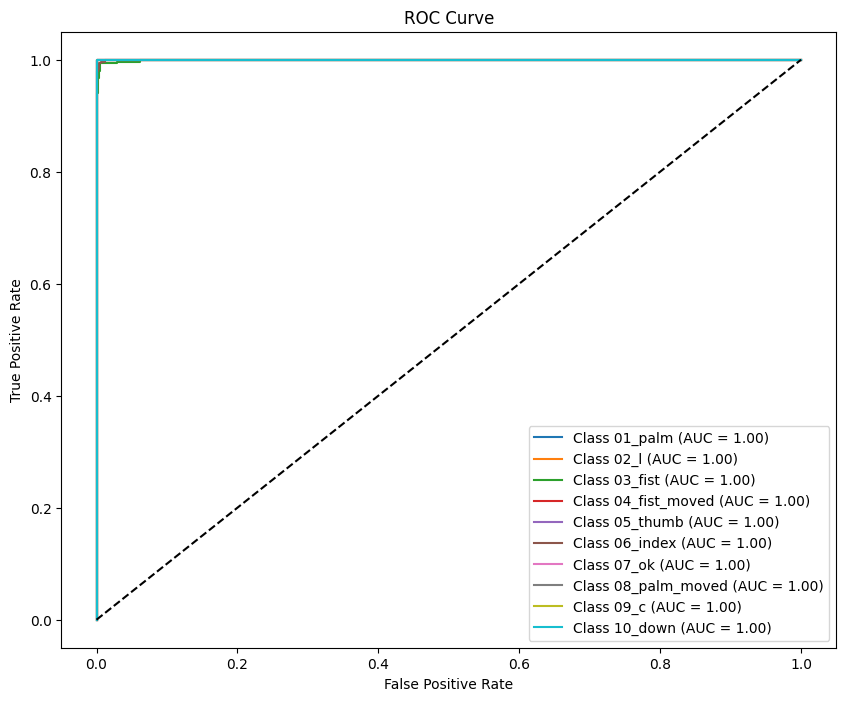

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(Y_test_int, classes=list(range(len(label_encoder.classes_))))


fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")


plt.plot([0, 1], [0, 1], 'k--') #Random guess line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [16]:
from sklearn.metrics import roc_auc_score

micro_auc = roc_auc_score(y_test_binarized, y_pred, average='micro')
macro_auc = roc_auc_score(y_test_binarized, y_pred, average='macro')

print(f"Micro-average AUC: {micro_auc}")
print(f"Macro-average AUC: {macro_auc}")


Micro-average AUC: 0.9998392098765432
Macro-average AUC: 0.9999393827160494
